In [18]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.utils import shuffle
from xgboost import XGBClassifier
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.metrics import accuracy_score

In [4]:
data = pd.read_csv('Final_Data_Bal.csv')
data = shuffle(data)
data

,class,mean,std,var,kurtosis,skewness,quantile1,quantile2,quantile3,quantile4,...,fquantile5,fquantile6,ftrimed_Mean,fcofvar,finvcofvar,fminimum,fmaxmimum,fmedian,fabsenergy,fIQR
4020,0,0.042295,0.000245,7.970000e-08,0.016219,0.563677,0.168714,0.078189,0.064179,0.027577,...,0.003465,0.001410,0.379944,0.762736,0.438515,0.991785,0.001022,0.752506,0.000078,0.008928
61,0,0.039465,0.000266,9.240000e-08,0.027888,0.583498,0.157428,0.072959,0.059885,0.025732,...,0.028516,0.015039,0.386285,0.762915,0.565344,0.959799,0.010773,0.748317,0.001183,0.037624
13722,1,0.162959,0.050628,2.567046e-03,0.100107,0.390012,0.131271,0.142318,0.240333,0.117428,...,0.028982,0.015409,0.377537,0.762669,0.496654,0.944834,0.010409,0.748494,0.001586,0.048387
2296,0,0.043487,0.000147,3.350000e-08,1.000000,1.000000,0.173469,0.080393,0.065988,0.028354,...,0.023648,0.013189,0.363545,0.762743,0.420110,0.939031,0.010113,0.749878,0.002284,0.074932
4846,0,0.043487,0.000364,1.620000e-07,0.159442,0.699651,0.173469,0.080393,0.065988,0.028354,...,0.015000,0.008744,0.366987,0.762745,0.413114,0.971190,0.006574,0.746813,0.000703,0.026402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4794,0,0.045187,0.000880,8.450000e-07,0.752547,0.921797,0.180250,0.083536,0.068567,0.029462,...,0.021996,0.013331,0.390020,0.762905,0.567677,0.964494,0.011482,0.756629,0.000950,0.036885
11246,1,0.091215,0.088946,7.918020e-03,0.059182,0.590774,0.082851,0.040452,0.062004,0.075419,...,0.012541,0.008671,0.383646,0.763856,0.538197,0.984509,0.007440,0.758353,0.000445,0.027262
1079,0,0.019860,0.000292,1.090000e-07,0.592256,0.876372,0.079220,0.036714,0.030135,0.012949,...,0.011680,0.004470,0.381060,0.762676,0.494023,0.981063,0.002919,0.751785,0.000380,0.025308
15501,1,0.022454,0.005891,3.520000e-05,0.242734,0.717194,0.082851,0.038397,0.031516,0.013542,...,0.011339,0.005870,0.370425,0.762750,0.395701,0.969669,0.003943,0.750638,0.000505,0.021413


In [5]:
# In practice, feature selection should be done after data pre-processing,
# so ideally, all the categorical variables are encoded into numbers,
# and then you can assess how deterministic they are of the target

# select numerical columns:

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

(17308, 39)

In [6]:
X = data.drop(labels=['class'], axis=1)
y = data['class']

In [7]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=0)

X_train.shape, X_test.shape

((13846, 38), (3462, 38))

In [8]:
# find and remove correlated features
# in order to reduce the feature space a bit
# so that the algorithm takes shorter

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.8)
print('correlated features: ', len(set(corr_features)) )

correlated features:  22


In [9]:
# removed correlated  features
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((13846, 16), (3462, 16))

In [10]:
X_train.columns

Index(['mean', 'std', 'var', 'kurtosis', 'skewness', 'quantile1', 'quantile3',
       'cofvar', 'invcofvar', 'IQR', 'fmean', 'fstd', 'fskewness',
       'ftrimed_Mean', 'fcofvar', 'finvcofvar'],
      dtype='object')

In [12]:
# step forward feature selection
# Select 10 features based on optimal ROC_AUC scoring criteria

sfs1 = SFS(XGBClassifier(n_estimators=100,early_stopping_rounds = 10), 
         k_features=10, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=5)

#feature_names = ('mean', 'std', 'var', 'kurtosis', 'skewness', 'quantile1', 'quantile3','cofvar', 'invcofvar', 'IQR', 'fmean', 'fstd', 'fskewness','ftrimed_Mean', 'fcofvar', 'finvcofvar')
#custom_feature_names=feature_names
sfs1 = sfs1.fit(np.array(X_train.fillna(0)), y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   40.6s finished

[2020-03-30 13:47:00] Features: 1/10 -- score: 0.9693055267642139[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   41.1s finished

[2020-03-30 13:47:41] Features: 2/10 -- score: 0.9792722939506893[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:   39.0s finished

[2020-03-30 13:48:20] Features: 3/10 -- score: 0.9838946145632473[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [13]:
sfs1.subsets_

{1: {'feature_idx': (5,),
  'cv_scores': array([0.96498195, 0.96894186, 0.96785843, 0.97327555, 0.97146984]),
  'avg_score': 0.9693055267642139,
  'feature_names': ('quantile1',)},
 2: {'feature_idx': (0, 5),
  'cv_scores': array([0.97509025, 0.97797039, 0.97688696, 0.98410979, 0.98230408]),
  'avg_score': 0.9792722939506893,
  'feature_names': ('mean', 'quantile1')},
 3: {'feature_idx': (0, 5, 10),
  'cv_scores': array([0.97906137, 0.98374865, 0.98483207, 0.98519321, 0.98663778]),
  'avg_score': 0.9838946145632473,
  'feature_names': ('mean', 'quantile1', 'fmean')},
 4: {'feature_idx': (0, 5, 6, 10),
  'cv_scores': array([0.98194946, 0.98483207, 0.98627663, 0.98844348, 0.98519321]),
  'avg_score': 0.985338970786675,
  'feature_names': ('mean', 'quantile1', 'quantile3', 'fmean')},
 5: {'feature_idx': (0, 4, 5, 6, 10),
  'cv_scores': array([0.98194946, 0.98736006, 0.98916576, 0.98844348, 0.98699892]),
  'avg_score': 0.9867835356115217,
  'feature_names': ('mean', 'skewness', 'quantile1'

In [15]:
selected_feat= X_train.columns[list(sfs1.k_feature_idx_)]
selected_feat

Index(['mean', 'var', 'kurtosis', 'skewness', 'quantile1', 'quantile3',
       'fmean', 'fstd', 'fskewness', 'fcofvar'],
      dtype='object')

In [20]:
def run_xgboost(X_train, X_test, y_train, y_test):
    rf = XGBClassifier(n_estimators=1000,early_stopping_rounds = 10)
    rf.fit(X_train, y_train)
    print('Train set')
    pred = rf.predict_proba(X_train)
    print('XgBoost roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Xgboost roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [21]:
# evaluate performance of algorithm built
# using selected features

run_xgboost(X_train[selected_feat].fillna(0),
                  X_test[selected_feat].fillna(0),
                  y_train, y_test)

Train set
XgBoost roc-auc: 1.0
Test set
Xgboost roc-auc: 0.9990977175558861


In [30]:
import pandas as pd
pd = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T

In [34]:
pd = pd.drop(['cv_scores','ci_bound','std_dev','std_err'], axis=1)

In [36]:
pd.to_csv (r'Feature_Selection_Methods.csv', index = False, header=True)

In [23]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

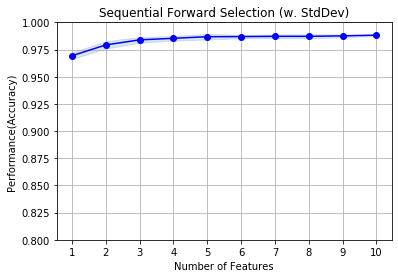

In [25]:
fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')

plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.ylabel("Performance(Accuracy)")
plt.grid()
plt.show()